In [1]:
!pip install torch torchvision gdown -q

In [20]:
import gdown
import os
from PIL import Image
import gc

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import average_precision_score


import random
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

from resnet.ResNet import resnet18, resnet152
from utils.trainer import Trainer

In [12]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [5]:
def clean():
    torch.cuda.empty_cache()
    gc.collect()

In [6]:
clean()

In [7]:
os.environ['CUDA_VISIABLE_DEVICES']='0'

In [3]:
device = torch.device('cuda')

In [ ]:
!nvidia-smi

Tue May 23 10:01:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Multi-class problem

In [ ]:
gdown.download("https://drive.google.com/file/d/1q8Jc3LyQfNxuzAAvIQFAcwrgliHRijix/view?usp=share_link","./class_data.zip", quiet=False, fuzzy=True)
!unzip -q ./class_data.zip

Downloading...
From: https://drive.google.com/uc?id=1q8Jc3LyQfNxuzAAvIQFAcwrgliHRijix
To: /content/class_data.zip
100%|██████████| 113M/113M [00:03<00:00, 33.2MB/s]


In [ ]:
if not os.path.exists('multi_class_output'):
    os.mkdir('multi_class_output')
else:
    print('multi_class_output exists')

In [ ]:
from dl2023_project.data.multi_class_build_data import build_dataloader

BATCH_SIZE=8

transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataloader, test_dataloader, trainset_len, testset_len, NUM_CLASS = build_dataloader(transfrom, BATCH_SIZE)

### ResNet18

#### Training 

In [ ]:
criteriation=nn.CrossEntropyLoss()

In [ ]:
resnet_18 = resnet18(num_channels=3, num_classes = NUM_CLASS).cuda()

In [ ]:
optimizer = torch.optim.Adam(resnet_18.parameters(), lr=0.001)

In [ ]:
NAME = 'ResNet18'

trainer = Trainer(resnet_18, 
                  criteriation,
                  device,
                  train_dataloader,
                  test_dataloader,
                  trainset_len,
                  testset_len,
                  optimizer,
                  epochs=9,
                  path_output='multi_class_output/{name}.pt'.format(name=NAME),
                  multi_label=False
                 )

In [ ]:
trainer.training()

[1]/[9] Epoch starts
	 Batch train loss: 1.291607141494751, accuracy 0.5
	 Batch train loss: 0.876563310623169, accuracy 0.875
	 Batch train loss: 0.7487624883651733, accuracy 0.625
	 Batch train loss: 0.331017404794693, accuracy 1.0
	 Batch train loss: 0.4691700041294098, accuracy 0.75
[1]/[9] End epoch: train loss: 0.8049032932258315, val loss: 0.5470364188289139
	 Epoch train accuracy: 0.6466807126998901, val accuracy: 0.748291113791717

[2]/[9] Epoch starts
	 Batch train loss: 0.62690669298172, accuracy 0.75
	 Batch train loss: 0.207528755068779, accuracy 1.0
	 Batch train loss: 0.5875141024589539, accuracy 0.875
	 Batch train loss: 0.41516542434692383, accuracy 0.75
	 Batch train loss: 0.1472444236278534, accuracy 0.875
[2]/[9] End epoch: train loss: 0.43726888004317394, val loss: 0.25218140699560593
	 Epoch train accuracy: 0.8256502747535706, val accuracy: 0.8982710092480901

[3]/[9] Epoch starts
	 Batch train loss: 0.2986351549625397, accuracy 0.75
	 Batch train loss: 0.97857332

#### Evaluate model

In [ ]:
# save cuda memory
# culd skip

del resnet_18

resnet_18 = resnet18(num_channels=3, num_classes = NUM_CLASS).cuda()

In [ ]:
resnet_18.load_state_dict(torch.load(f'multi_class_output/ResNet18.pt')['model_state_dict'])
resnet_18 = resnet_18.to(device)

In [ ]:
_, _, preds = trainer.val()

In [ ]:
prediciton = pd.DataFrame([preds[0].cpu().numpy(), preds[1].cpu().numpy()]).T
prediciton.rename = ['labels', 'predictions']

prediciton.to_csv('multi_class_output/{name}.csv'.format(name=NAME), index=False)

### ResNet152


#### Training 

In [ ]:
resnet_152 = resnet152(num_channels=3, num_classes = NUM_CLASS).cuda()

In [ ]:
optimizer = torch.optim.Adam(resnet_152.parameters(), lr=0.001)

In [ ]:
NAME = 'ResNet152'

trainer = Trainer(resnet_152, 
                  criteriation,
                  device,
                  train_dataloader,
                  test_dataloader,
                  trainset_len,
                  testset_len,
                  optimizer,
                  epochs=9,
                  path_output='multi_class_output/{name}.pt'.format(name=NAME),
                  multi_label=False
                 )

In [ ]:
trainer.training()

[1]/[9] Epoch starts
	 Batch train loss: 1.8190600872039795, accuracy 0.125
	 Batch train loss: 1.3815158605575562, accuracy 0.5
	 Batch train loss: 1.3088819980621338, accuracy 0.625
	 Batch train loss: 0.7719427347183228, accuracy 0.75
	 Batch train loss: 1.051823377609253, accuracy 0.375
[1]/[9] End epoch: train loss: 1.1932808447161916, val loss: 0.6726938046484421
	 Epoch train accuracy: 0.42643365263938904, val accuracy: 0.6690792119018898

[2]/[9] Epoch starts
	 Batch train loss: 0.8099243640899658, accuracy 0.625
	 Batch train loss: 0.4338819980621338, accuracy 0.75
	 Batch train loss: 0.26415908336639404, accuracy 1.0
	 Batch train loss: 1.016061544418335, accuracy 0.625
	 Batch train loss: 0.3886076807975769, accuracy 1.0
[2]/[9] End epoch: train loss: 0.6480698689011741, val loss: 0.9630211943404855
	 Epoch train accuracy: 0.7109571099281311, val accuracy: 0.6980297547245677

[3]/[9] Epoch starts
	 Batch train loss: 0.09475422650575638, accuracy 1.0
	 Batch train loss: 0.829

#### Evaluate model

In [ ]:
# save cuda memory
# culd skip

del resnet_152

resnet_152 = resnet152(num_channels=3, num_classes = NUM_CLASS).cuda()

In [ ]:
resnet_152.load_state_dict(torch.load(f'multi_class_output/ResNet152.pt')['model_state_dict'])
resnet_152 = resnet_152.to(device)

In [ ]:
_, _, preds = trainer.val()

In [ ]:
prediciton = pd.DataFrame([preds[0].cpu().numpy(), preds[1].cpu().numpy()]).T
prediciton.rename = ['labels', 'predictions']

prediciton.to_csv('multi_class_output/{name}.csv'.format(name=NAME), index=False)

### Metrics

In [ ]:
models = [resnet_18, resnet_152]
models_name = ['resnet18: ', 'resnet152: ']

In [ ]:
metrics = [met for met in os.listdir('multi_class_output') if met[-12:]=='_metrics.csv']

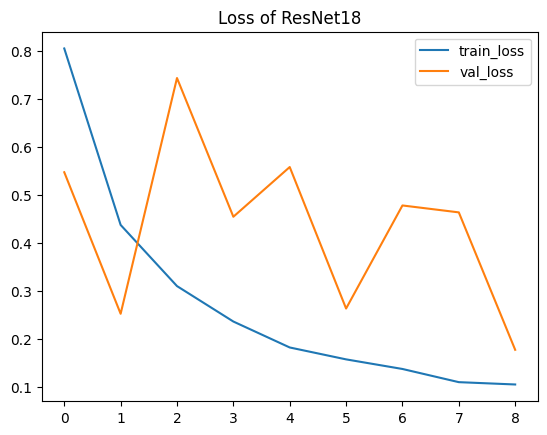

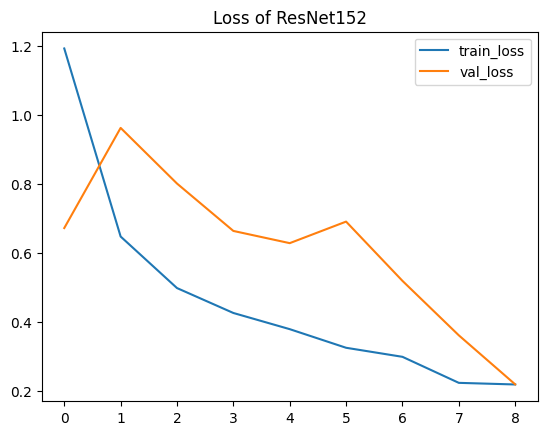

In [ ]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('multi_class_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    train_loss = metric_file['train_loss']
    val_loss = metric_file['val_loss']
    plt.plot(np.arange(len(train_loss)), train_loss, label='train_loss')
    plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
    plt.legend()
    plt.title(f'Loss of {metric_file_name[:-12]}')
    plt.show()

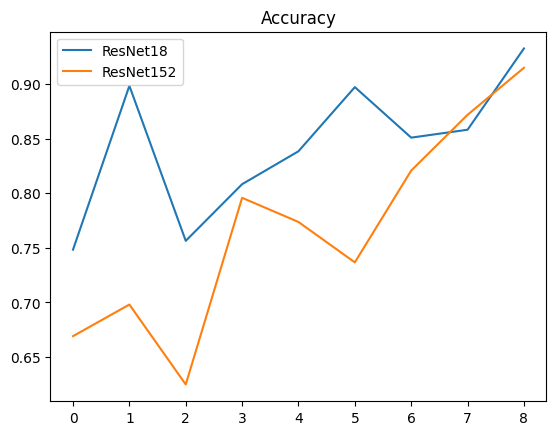

In [ ]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('multi_class_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    val_accuracy = metric_file['val accuracy']
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, label=metric_file_name[:-12])
    plt.legend()
    plt.title('Accuracy')

## Multi-label problem

In [19]:
gdown.download("https://drive.google.com/file/d/15aX9gKeSlGoUJBHAQGqkL5euq0kDKkwg/view?usp=share_link","./label_data.zip", quiet=False, fuzzy=True)
!unzip -q ./label_data.zip

Downloading...
From: https://drive.google.com/uc?id=15aX9gKeSlGoUJBHAQGqkL5euq0kDKkwg
To: /content/label_data.zip
100%|██████████| 4.51G/4.51G [01:00<00:00, 74.8MB/s]


In [21]:
# Clean dataset: RUN ONLY ONCE
data = pd.read_csv('sample_labels.csv')
data['lables'] = data['Finding Labels'].str.split('|')
data['Image Index'] = './sample/images/' + data['Image Index']

chen = []
for path_img in data['Image Index'].values:
    img = Image.open(path_img)
    chen.append(transforms.ToTensor()(img).shape)

bad_img = data.loc[pd.DataFrame(chen)[0] > 1, 'Image Index'].values

for path_img in bad_img:
    img = plt.imread(path_img)
    img = img[:, :, 0]
    img = Image.fromarray(np.uint8(img * 255), 'L')
    img.save(path_img,"PNG")

In [22]:
if not os.path.exists('multi_label_output'):
    os.mkdir('multi_label_output')
else:
    print('multi_label_output exists')

In [23]:
from dl2023_project.data.multi_label_build_data import build_dataloader

BATCH_SIZE=4

transfrom = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataloader, test_dataloader, trainset_len, testset_len, NUM_CLASS = build_dataloader(transfrom, BATCH_SIZE)

### Resnet18

#### Training

In [24]:
resnet_18 = resnet18(num_channels = 1, num_classes = NUM_CLASS).cuda()

In [25]:
criteriation = nn.BCELoss()

In [26]:
optimizer = torch.optim.Adam(resnet_18.parameters(), lr=1e-5)

In [27]:
NAME = 'ResNet18'

trainer = Trainer(resnet_18, 
                  criteriation,
                  device,
                  train_dataloader,
                  test_dataloader,
                  trainset_len,
                  testset_len,
                  optimizer,
                  epochs=9,
                  path_output='multi_label_output/{name}.pt'.format(name=NAME),
                  multi_label=True
                 )

In [28]:
trainer.training()

[1]/[9] Epoch starts
	 Batch train loss: 0.7123063206672668, accuracy 0.775
	 Batch train loss: 0.4618370532989502, accuracy 0.7291423853923854
	 Batch train loss: 0.27301883697509766, accuracy 0.6944444444444444
	 Batch train loss: 0.12007353454828262, accuracy 1.0
	 Batch train loss: 0.12593820691108704, accuracy 0.875
[1]/[9] End epoch: train loss: 0.28669271814318137, val loss: 0.2223302671198968
	 Epoch train accuracy: 0.6748530085979914, val accuracy: 0.6808953100043644

[2]/[9] Epoch starts
	 Batch train loss: 0.10321743041276932, accuracy 1.0
	 Batch train loss: 0.30806151032447815, accuracy 0.5157738095238096
	 Batch train loss: 0.2010999470949173, accuracy 0.6875
	 Batch train loss: 0.13898228108882904, accuracy 0.8125
	 Batch train loss: 0.32747340202331543, accuracy 0.6509920634920635
[2]/[9] End epoch: train loss: 0.21182893254153573, val loss: 0.21184227073251086
	 Epoch train accuracy: 0.6922770775466277, val accuracy: 0.6839646125094385

[3]/[9] Epoch starts
	 Batch tra

#### Evaluate model

In [ ]:
del resnet_18

resnet_18 = resnet18(num_channels=1, num_classes = NUM_CLASS).cuda()

In [ ]:
resnet_18.load_state_dict(torch.load(f'multi_label_output/ResNet18.pt')['model_state_dict'])
resnet_18 = resnet_18.to(device)

In [ ]:
trainer = Trainer(resnet_18, 
                  criteriation,
                  device,
                  train_dataloader,
                  test_dataloader,
                  trainset_len,
                  testset_len,
                  path_output='multi_label_output/{name}.pt'.format(name=NAME),
                  multi_label=True
                 )

In [ ]:
_, _, preds = trainer.val()

In [ ]:
pd.DataFrame(preds[0].cpu().numpy()).to_csv('multi_label_output/true_{name}.csv'.format(name=NAME), index=False)
pd.DataFrame(preds[1].cpu().numpy()).to_csv('multi_label_output/pred_{name}.csv'.format(name=NAME), index=False)

### Resnet152

#### Training

In [34]:
resnet_152 = resnet152(num_channels = 1, num_classes = NUM_CLASS).cuda()

In [35]:
criteriation = nn.BCELoss()

In [36]:
optimizer = torch.optim.Adam(resnet_152.parameters(), lr=1e-5)

In [37]:
NAME = 'ResNet152'

trainer = Trainer(resnet_152, 
                  criteriation,
                  device,
                  train_dataloader,
                  test_dataloader,
                  trainset_len,
                  testset_len,
                  optimizer,
                  epochs=9,
                  path_output='multi_label_output/{name}.pt'.format(name=NAME),
                  multi_label=True
                 )

In [38]:
trainer.training()

[1]/[9] Epoch starts
	 Batch train loss: 0.7543862462043762, accuracy 0.11079198579198579
	 Batch train loss: 0.24188853800296783, accuracy 0.75
	 Batch train loss: 0.0900890976190567, accuracy 1.0
	 Batch train loss: 0.12543728947639465, accuracy 0.8125
	 Batch train loss: 0.11215081810951233, accuracy 0.875
[1]/[9] End epoch: train loss: 0.2391643797939305, val loss: 0.21904556816784426
	 Epoch train accuracy: 0.661185211501822, val accuracy: 0.68172412032247

[2]/[9] Epoch starts
	 Batch train loss: 0.0930955782532692, accuracy 1.0
	 Batch train loss: 0.18433599174022675, accuracy 0.65625
	 Batch train loss: 0.13223296403884888, accuracy 0.8125
	 Batch train loss: 0.20087340474128723, accuracy 0.7958333333333334
	 Batch train loss: 0.14445145428180695, accuracy 0.8125
[2]/[9] End epoch: train loss: 0.21295472240966298, val loss: 0.22025280506960734
	 Epoch train accuracy: 0.6912104334691922, val accuracy: 0.6807031808760176

[3]/[9] Epoch starts
	 Batch train loss: 0.176730394363403

#### Evaluate model

In [39]:
del resnet_152

resnet_152 = resnet152(num_channels=1, num_classes = NUM_CLASS).cuda()

In [40]:
resnet_152.load_state_dict(torch.load(f'multi_label_output/ResNet152.pt')['model_state_dict'])
resnet_152 = resnet_152.to(device)

In [41]:
trainer = Trainer(resnet_152, 
                  criteriation,
                  device,
                  train_dataloader,
                  test_dataloader,
                  trainset_len,
                  testset_len,
                  path_output='multi_label_output/{name}.pt'.format(name=NAME),
                  multi_label=True
                 )

In [42]:
_, _, preds = trainer.val()

In [43]:
pd.DataFrame(preds[0].cpu().numpy()).to_csv('multi_label_output/true_{name}.csv'.format(name=NAME), index=False)
pd.DataFrame(preds[1].cpu().numpy()).to_csv('multi_label_output/pred_{name}.csv'.format(name=NAME), index=False)

### Metrics

In [44]:
metrics = [met for met in os.listdir('multi_label_output') if met[-12:]=='_metrics.csv']

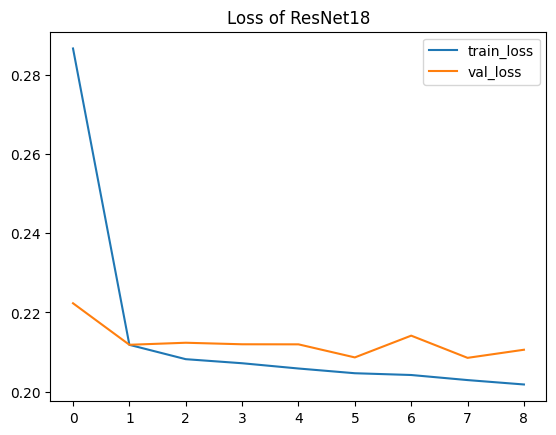

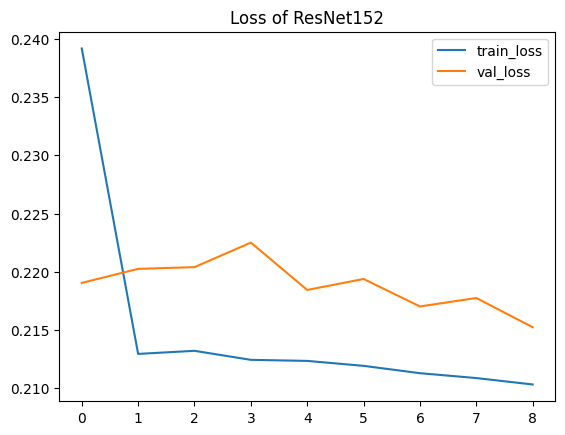

In [45]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('multi_label_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    train_loss = metric_file['train_loss']
    val_loss = metric_file['val_loss']
    plt.plot(np.arange(len(train_loss)), train_loss, label='train_loss')
    plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
    plt.legend()
    plt.title(f'Loss of {metric_file_name[:-12]}')
    plt.show()

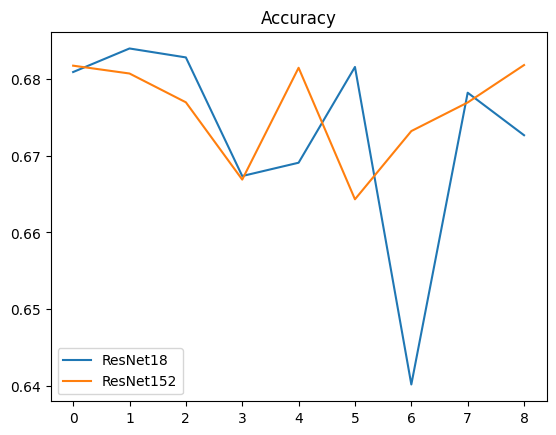

In [46]:
for metric_file_name in metrics:
    
    path_metric = os.path.join('multi_label_output', metric_file_name)
    metric_file = pd.read_csv(path_metric)
    
    val_accuracy = metric_file['val accuracy']
    plt.plot(np.arange(len(val_accuracy)), val_accuracy, label=metric_file_name[:-12])
    plt.legend()
    plt.title('Accuracy')